In [1]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

In [2]:
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 100)
# # ##### 各関数での実行時間を保存するためのCSVの空データを作成するための処理 #####
# # Processes = []
# # for i in range(1,16):
# #     Processes.append(i*i)
# # for j in range(9):
# #     Processes.append(2**j)
# # Processes = list(set(Processes))
# # Processes.sort()
# # index = classes
# # EmptyDF = pd.DataFrame(index=index, columns=Processes)
# # for benchmark in benchmarks:
# #     EmptyDF.to_csv(f"./csv_files/ExecTime@{benchmark}.csv")

# ##### 各ベンチマークの実行時間を記録する処理
# # # Benchmarks = []
# # # for benchmark in benchmarks:
# # #     Benchmarks.append(benchmark.upper())
# # # print(Benchmarks)

# # Processes = [8, 16, 32, 64, 128, 256]
# # for process in Processes:
# #     TimeDataList = return_TimeDataList(process)
# #     for DictData in TimeDataList:
# #         benchmark = DictData.benchmark
# #         process = DictData.process
# #         BenchmarkClass = DictData.BenchmarkClass
# #         time = DictData.time
# #         FillCSV(benchmark=benchmark, process=process, BenchmarkClass=BenchmarkClass, time=time)

# # # print(TimeDataList[0].return_AllData())




# # for benchmark in ['bt', 'mg', 'sp']:
# FixClass = "B"
# for benchmark in ['mg']:
#     print(f"benchmark={benchmark}")
#     TargetDF = return_FixedClassModelDF(benchmark=benchmark, FixClass=FixClass)
#     BestModelsInTargetDF = BestModelsInDF(TargetDF)
#     print(BestModelsInTargetDF)
#     TargetDF = return_ErrorRateFixedClassDFwithAverage(benchmark = benchmark , FixClass=FixClass)
#     print(TargetDF)

# # for benchmark in ['bt', 'mg', 'sp']:
# for benchmark in ['mg']:
#     ProcessExcludeBTSP = [1,2,4,8,16,32,64,128,256]
#     ProcessIncludeBTSP = [1, 4, 16, 64, 256]

#     TestRates = [0, 0.2, 0.4, 0.6, 0.8]
#     if(benchmark == "bt" or benchmark == "sp"):
#         processes=ProcessIncludeBTSP
#     else:
#         processes=ProcessExcludeBTSP
#     RawDataList = return_fixed_class(BenchMark=benchmark, Processes=processes,FixedBenchMarkClass=FixClass)
#     RawDataDF = pd.concat(RawDataList, axis=1)
#     print(RawDataDF)
# print('SET_CLASS' in RawDataDF.index.tolist())
# print(RawDataDF.loc['SET_CLASS'])

# for benchmark in benchmarks:
#     print(return_ErrorRateFixedProcess_AveragePredictCostRealCost(benchmark=benchmark, FixProcess=64, predict_class="D"))
#     print(return_ErrorRateFixedClass_AveragePredictCostRealCost(benchmark=benchmark, FixClass="B", predict_process=256))

# "SET_CLASS"に代表される関数が、プロファイル数が2個のときだけ突飛な平均誤差率を出力する。その原因は学主データ二個だと基本的に線形モデルを採用することになるが、そうすると、実際の最適モデルが反比例や対数だった場合に予測値と実測値が大幅にずれる。したがって、プロファイル数が2個のときにだけ突飛な平均誤差率を出力する。

# 実際に予測することになる関数のみだけを、表示するようにして、出力されるデータを見やすくする(↑の話)。

# 表のタイトルをそのまま保存時のファイル名にすればええんか

In [3]:
# 問題サイズDに対する予測で、プロファイル数３の時の平均平均誤差率 < プロファイル数４の時の平均平均誤差率　となっているものを探す
Fixed="Process"
Fix=64
FixProcess=Fix
Predict="D"
predict_class=Predict
EnableTitle=False
SaveGraph=False
for benchmark in benchmarks:
    ErrorRateFixedProcess = return_ErrorRateFixedProcessAverageAndCosts(benchmark=benchmark, FixProcess=FixProcess, predict_class=predict_class)
    print(benchmark)
    ErrorRateFixedProcess

bt


,Average,PredictCosts
"['A', 'B', 'C', 'D']",51.912,31604.48
"['A', 'B', 'C']",35.667371,1852.16
"['A', 'B']",35.628016,430.08
['A'],36.060694,79.36


cg


,Average,PredictCosts
"['A', 'B', 'C', 'D']",11.926136,14526.72
"['A', 'B', 'C']",10.475864,513.92
"['A', 'B']",253.014091,99.20
['A'],28.185318,3.20


ep


,Average,PredictCosts
"['A', 'B', 'C', 'D']",0.0,7335.04
"['A', 'B', 'C']",0.0,507.52
"['A', 'B']",0.0,81.28
['A'],0.0,26.88


ft


,Average,PredictCosts
"['A', 'B', 'C', 'D']",13.059577,10872.96
"['A', 'B', 'C']",15.726654,541.44
"['A', 'B']",912.363038,108.80
['A'],28.298731,9.60


is


,Average,PredictCosts
"['A', 'B', 'C', 'D']",3.741429,652.16
"['A', 'B', 'C']",3.741429,37.12
"['A', 'B']",3.741381,9.60
['A'],4.927238,1.92


lu


,Average,PredictCosts
"['A', 'B', 'C', 'D']",13.213214,18626.56
"['A', 'B', 'C']",15.199595,1416.32
"['A', 'B']",55.624714,316.16
['A'],25.230548,64.00


mg


,Average,PredictCosts
"['A', 'B', 'C', 'D']",8.663875,2456.96
"['A', 'B', 'C']",52.836969,128.64
"['A', 'B']",584.405375,20.48
['A'],46.868281,3.84


sp


,Average,PredictCosts
"['A', 'B', 'C', 'D']",25.874171,41757.44
"['A', 'B', 'C']",20.977732,1737.60
"['A', 'B']",20.91822,365.44
['A'],21.572512,64.64


FixProcess_bt


,S,W,A,B,C,D
Name,,,,,,
".TAU_application, MPBT, MPI_Comm_rank(), MPI_Comm_size(), MPI_Init(), SETUP_MPI",1.0,1.0,1.0,1.0,1.0,1.0
MPI_Bcast(),1.0,1.0,1.0,1.0,6.0,1.0


<Figure size 432x288 with 0 Axes>

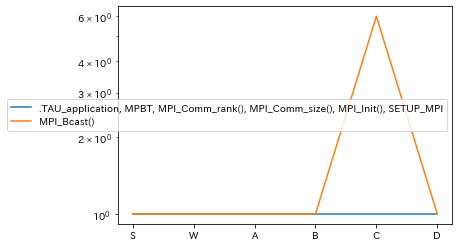

FixProcess_cg


,A,B,C,D
Name,,,,
".TAU_application, ALLOC_SPACE, CG, INITIALIZE_MPI, MAKEA, MPI_Barrier(), MPI_Bcast(), MPI_Comm_rank(), MPI_Comm_size(), MPI_Finalize(), MPI_Init(), MPI_Reduce(), SETUP_PROC_INFO, SETUP_SUBMATRIX_INFO, SPARSE",1,1.0,1.0,1.0
CONJ_GRAD,16,76.0,76.0,101.0
ICNVRT,180347,1706010.0,3936140.0,44047200.0
"MPI_Irecv(), MPI_Send(), MPI_Wait()",4208,19988.0,19988.0,26563.0
"SPRNVC, VECSET",14000,75000.0,150000.0,1500000.0


<Figure size 432x288 with 0 Axes>

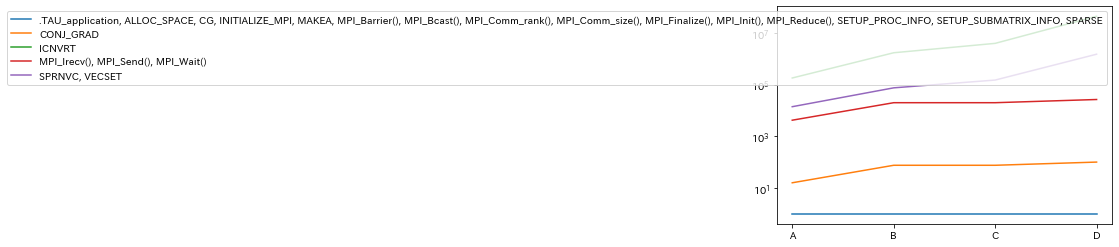

FixProcess_ep


,A,B,C,D
Name,,,,
".TAU_application, EMBAR, MPI_Barrier(), MPI_Bcast(), MPI_Comm_rank(), MPI_Comm_size(), MPI_Finalize(), MPI_Init()",1,1,1,1
MPI_Allreduce(),4,4,4,4


<Figure size 432x288 with 0 Axes>

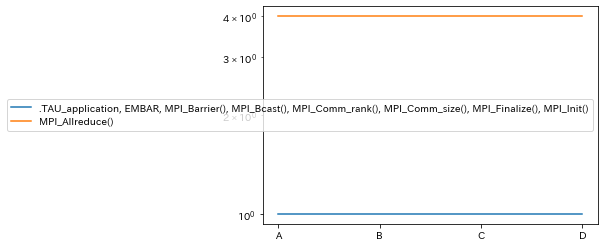

FixProcess_ft


,A,B,C,D
Name,,,,
".TAU_application, ALLOC_SPACE, FT, MPI_Barrier(), MPI_Comm_rank(), MPI_Comm_size(), MPI_Finalize(), MPI_Init(), SETUP, VERIFY",1.00000,1.00000,1.00000,1.000000e+00
CFFTS1,16.00000,44.00000,44.00000,5.400000e+01
"CFFTS2, FFT, MPI_Alltoall(), TRANSPOSE2_FINISH, TRANSPOSE2_GLOBAL, TRANSPOSE2_LOCAL",8.00000,22.00000,22.00000,2.700000e+01
CFFTZ,2048.00000,14080.00000,33792.00000,2.764800e+05
"CHECKSUM, EVOLVE, MPI_Reduce(), TRANSPOSE_X_YZ",6.00000,20.00000,20.00000,2.500000e+01
"COMPUTE_INDEXMAP, COMPUTE_INITIAL_CONDITIONS, FFT_INIT, MPI_Comm_split(), TRANSPOSE_XY_Z",2.00000,2.00000,2.00000,2.000000e+00
FFTZ2,15360.00000,115456.00000,304128.00000,2.820100e+06
ILOG2,26.00000,68.00000,68.00000,8.300000e+01
IPOW46,4.00000,4.00000,4.00000,4.000000e+00


<Figure size 432x288 with 0 Axes>

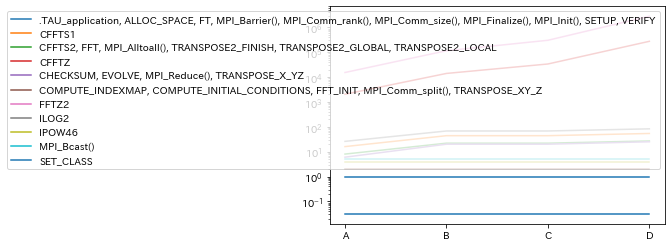

FixProcess_is


,A,B,C,D
Name,,,,
".TAU_application, MPI_Bcast(), MPI_Comm_dup(), MPI_Comm_rank(), MPI_Comm_size(), MPI_Finalize(), MPI_Init(), double_find_my_seed(int_int_long_double_double), int_main(int_char_**), void_alloc_space(void), void_create_seq(double_double), void_full_verify(void)",1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
"MPI_Allreduce(), MPI_Alltoall(), MPI_Alltoallv(), void_rank(int)",1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01
"MPI_Irecv(), MPI_Wait()",9.687500e-01,9.687500e-01,9.687500e-01,9.960940e-01
MPI_Reduce(),2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
MPI_Send(),9.687500e-01,9.687500e-01,9.687500e-01,9.921880e-01
double_randlc(double_*_double_*),1.048600e+06,4.194330e+06,1.677720e+07,3.401320e+07


<Figure size 432x288 with 0 Axes>

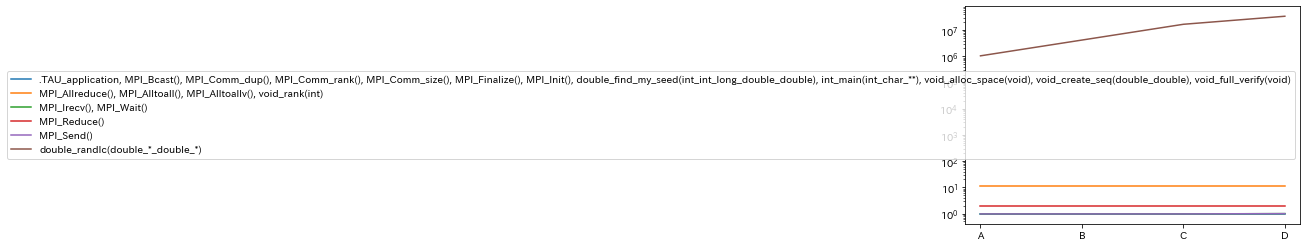

FixProcess_lu


,A,B,C,D
Name,,,,
".TAU_application, MPI_Comm_rank(), MPI_Comm_size(), MPI_Finalize(), MPI_Init()",1.000000,1.00,1.00,1.00
MPI_Allreduce(),11.000000,10.00,10.00,10.00
MPI_Bcast(),1.000000,10.00,10.00,10.00
"MPI_Irecv(), MPI_Wait()",0.996094,827.75,827.75,990.25
MPI_Send(),0.996094,82402.80,131348.00,398160.00


<Figure size 432x288 with 0 Axes>

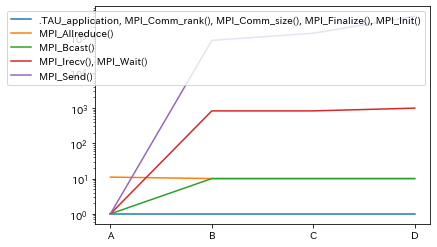

FixProcess_mg


,A,B,C,D
Name,,,,
".TAU_application, ALLOC_SPACE, MG_MPI, MPI_Comm_rank(), MPI_Comm_size(), MPI_Finalize(), MPI_Init(), MPI_Reduce()",1.000,1.000,1.000,1.000
BUBBLE,468.125,468.125,583.375,642.062
COMM3,119.000,487.000,550.000,1483.000
"COMM3_EX, INTERP, RPRJ3",35.000,147.000,168.000,459.000
"GIVE3, TAKE3",669.000,2733.000,3174.000,8439.000
"GIVE3_EX, TAKE3_EX",10.000,42.000,21.000,102.000
MG3P,5.000,21.000,21.000,51.000
MPI_Allreduce(),88.000,88.000,88.000,88.000
"MPI_Barrier(), POWER",6.000,6.000,6.000,6.000


<Figure size 432x288 with 0 Axes>

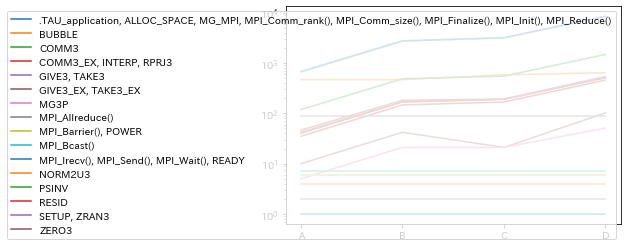

FixProcess_sp


,A,C
Name,,
".TAU_application, ALLOC_SPACE, MPI_Comm_rank(), MPI_Comm_size(), MPI_Finalize(), MPI_Init(), MPI_Reduce()",1.00,1.0
MPI_Allreduce(),88.00,2.0
MPI_Barrier(),6.00,2.0
MPI_Bcast(),7.00,4.0
MPI_Irecv(),2948.25,9630.0


<Figure size 432x288 with 0 Axes>

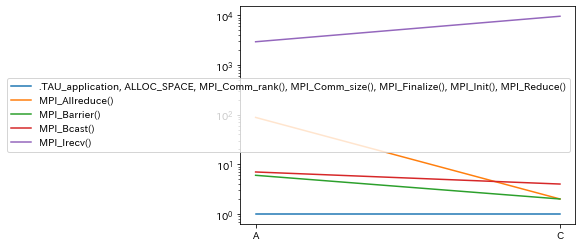

In [4]:
for benchmark in benchmarks:
    print(f"FixProcess_{benchmark}")
    FixProcessDF = return_summarized_Fixed_dataframe(BenchMark_name = benchmark, fixed="process")
    FixProcessDFwithoutNaN = FixProcessDF.dropna(how='any', axis=0)
    FixProcessDFwithoutNaN
    indice = FixProcessDFwithoutNaN.T.index.tolist()
    columns = FixProcessDFwithoutNaN.T.columns.tolist()
    plt.figure()
    x = indice
    for column in columns:
        y = FixProcessDFwithoutNaN.loc[column]
        plt.plot(x, y, label=column)
    plt.yscale('log')
    plt.legend()
    plt.show()

FixClass_bt


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
".TAU_application, MPBT, MPI_Comm_rank(), MPI_Comm_size(), MPI_Init(), SETUP_MPI",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
MPI_Bcast(),6.0,1.0,6.0,1.0,6.0,6.0,6.0,1.0,6.0


<Figure size 432x288 with 0 Axes>

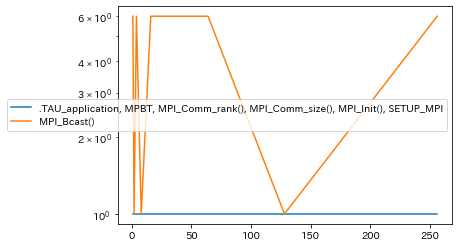

FixClass_cg


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
".TAU_application, ALLOC_SPACE, CG, INITIALIZE_MPI, MAKEA, MPI_Barrier(), MPI_Bcast(), MPI_Comm_rank(), MPI_Comm_size(), MPI_Finalize(), MPI_Init(), MPI_Reduce(), SETUP_PROC_INFO, SETUP_SUBMATRIX_INFO, SPARSE",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CONJ_GRAD,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0
ICNVRT,1984770.0,2263540.0,2821070.0,3936140.0,3936140.0,3936140.0,3936140.0,3936140.0,3936140.0
"MPI_Irecv(), MPI_Send(), MPI_Wait()",12236.0,12483.0,10982.0,13984.0,13984.0,19988.0,19988.0,25992.0,25992.0
"SPRNVC, VECSET",84375.0,93750.0,112500.0,150000.0,150000.0,150000.0,150000.0,150000.0,150000.0


<Figure size 432x288 with 0 Axes>

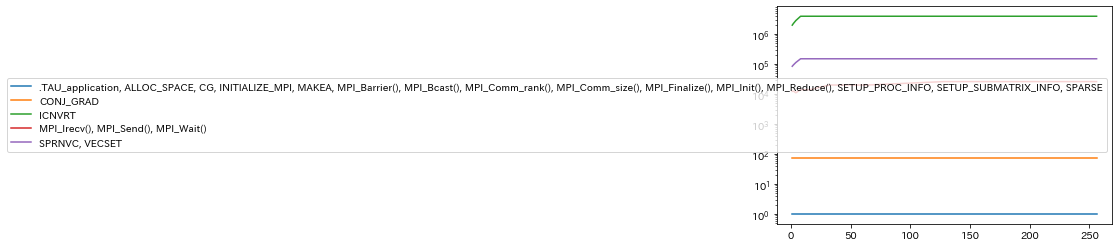

FixClass_ep


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
".TAU_application, EMBAR, MPI_Barrier(), MPI_Bcast(), MPI_Comm_rank(), MPI_Comm_size(), MPI_Finalize(), MPI_Init()",1,1,1,1,1,1,1,1,1
MPI_Allreduce(),4,4,4,4,4,4,4,4,4


<Figure size 432x288 with 0 Axes>

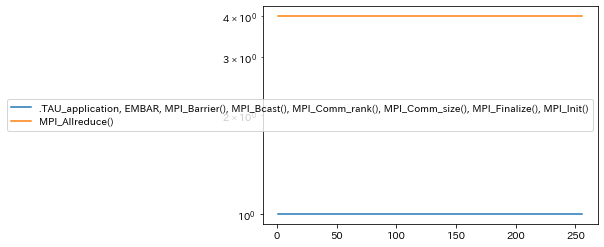

FixClass_ft


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
".TAU_application, ALLOC_SPACE, FT, MPI_Barrier(), MPI_Comm_rank(), MPI_Comm_size(), MPI_Finalize(), MPI_Init(), SETUP, VERIFY",1.0,1.0,1.00,1.000,1.0000,1.00000,1.000000,1.000000,1.000000
CFFTS1,22.0,44.0,44.00,44.000,44.0000,44.00000,44.000000,44.000000,44.000000
"CFFTS2, FFT",22.0,22.0,22.00,22.000,22.0000,22.00000,22.000000,22.000000,22.000000
CFFTZ,1081340.0,540672.0,270336.00,135168.000,67584.0000,33792.00000,16896.000000,8448.000000,4224.000000
"CHECKSUM, EVOLVE, MPI_Reduce()",20.0,20.0,20.00,20.000,20.0000,20.00000,20.000000,20.000000,20.000000
"COMPUTE_INDEXMAP, COMPUTE_INITIAL_CONDITIONS, FFT_INIT, MPI_Comm_split()",2.0,2.0,2.00,2.000,2.0000,2.00000,2.000000,2.000000,2.000000
FFTZ2,9732100.0,4866050.0,2433020.00,1216510.000,608256.0000,304128.00000,152064.000000,76032.000000,38016.000000
ILOG2,68.0,68.0,68.00,68.000,68.0000,68.00000,68.000000,68.000000,68.000000
IPOW46,4.0,4.0,4.00,4.000,4.0000,4.00000,4.000000,4.000000,4.000000


<Figure size 432x288 with 0 Axes>

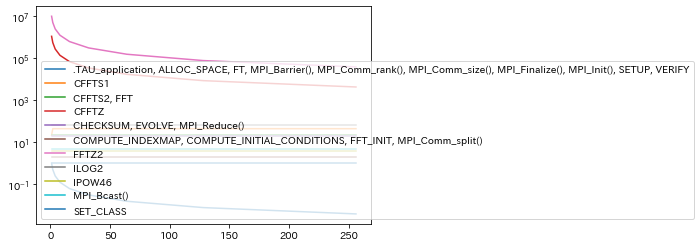

FixClass_is


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
".TAU_application, MPI_Bcast(), MPI_Comm_dup(), MPI_Comm_rank(), MPI_Comm_size(), MPI_Finalize(), MPI_Init(), double_find_my_seed(int_int_long_double_double), int_main(int_char_**), void_alloc_space(void), void_create_seq(double_double), void_full_verify(void)",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"MPI_Allreduce(), MPI_Alltoall(), MPI_Alltoallv(), void_rank(int)",11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0
MPI_Reduce(),2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
double_randlc(double_*_double_*),536871000.0,268435000.0,134218000.0,67108900.0,33554500.0,16777200.0,8388640.0,4194330.0,2097180.0


<Figure size 432x288 with 0 Axes>

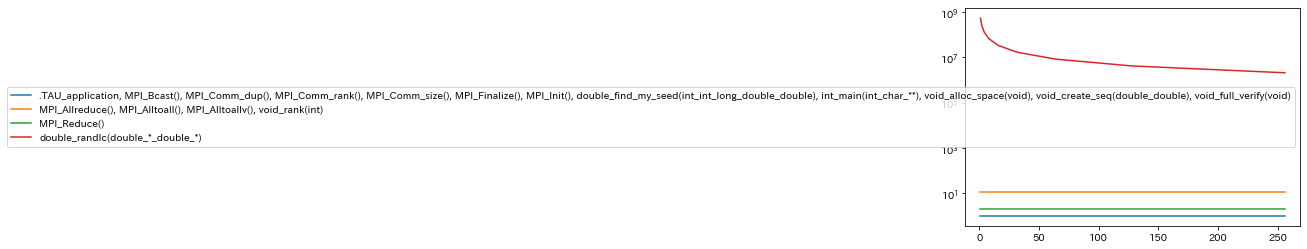

FixClass_lu


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
".TAU_application, ALLOC_SPACE, APPLU, BCAST_INPUTS, ERHS, ERROR, EXCHANGE_4, INIT_COMM, ISQRT2, MPI_Comm_rank(), MPI_Comm_size(), MPI_Finalize(), MPI_Init(), NEIGHBORS, PINTGR, PROC_GRID, READ_INPUT, SETCOEFF, SUBDOMAIN",1.0,1.0,1.00,1.000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000
"BLTS, BUTS, JACLD, JACU",6425600.0,6425600.0,3212800.00,3212800.000,1.606400e+06,1.606400e+06,803200.000000,803200.000000,401600.000000
EXACT,53562900.0,26781500.0,13390700.00,6695370.000,3.347680e+06,1.673840e+06,836921.000000,418460.000000,209230.000000
EXCHANGE_1,160640.0,160640.0,160640.00,160640.000,1.606400e+05,1.606400e+05,160640.000000,160640.000000,160640.000000
EXCHANGE_3,508.0,508.0,508.00,508.000,5.080000e+02,5.080000e+02,508.000000,508.000000,508.000000
EXCHANGE_5,2.0,2.0,1.00,1.000,5.000000e-01,5.000000e-01,0.250000,0.250000,0.125000
EXCHANGE_6,2.0,1.0,1.00,0.500,5.000000e-01,2.500000e-01,0.250000,0.125000,0.125000
L2NORM,4.0,4.0,4.00,4.000,4.000000e+00,4.000000e+00,4.000000,4.000000,4.000000
"MPI_Allreduce(), MPI_Bcast()",10.0,10.0,10.00,10.000,1.000000e+01,1.000000e+01,10.000000,10.000000,10.000000


<Figure size 432x288 with 0 Axes>

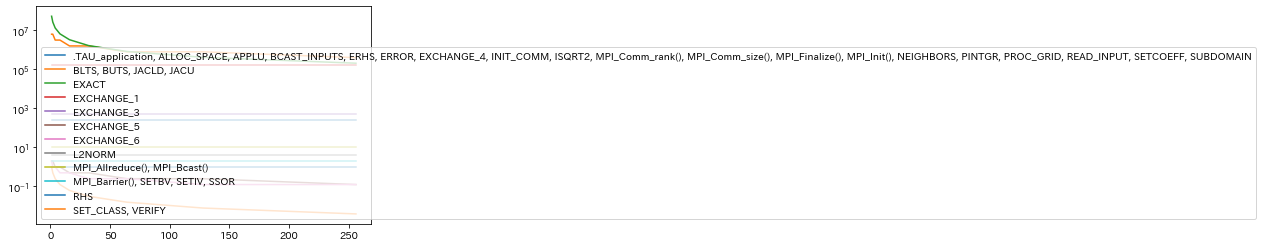

FixClass_mg


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
".TAU_application, ALLOC_SPACE, MG_MPI, MPI_Comm_rank(), MPI_Comm_size(), MPI_Finalize(), MPI_Init(), MPI_Reduce()",1.0,1.0,1.0,1.0,1.000,1.000,1.000,1.000,1.000
BUBBLE,666.0,647.0,632.5,613.0,583.375,583.375,529.125,498.875,471.828
COMM3,550.0,550.0,550.0,550.0,550.000,550.000,550.000,550.000,550.000
"COMM3_EX, INTERP, RPRJ3",168.0,168.0,168.0,168.0,168.000,168.000,168.000,168.000,168.000
MG3P,21.0,21.0,21.0,21.0,21.000,21.000,21.000,21.000,21.000
MPI_Allreduce(),88.0,88.0,88.0,88.0,88.000,88.000,88.000,88.000,88.000
"MPI_Barrier(), POWER",6.0,6.0,6.0,6.0,6.000,6.000,6.000,6.000,6.000
MPI_Bcast(),7.0,7.0,7.0,7.0,7.000,7.000,7.000,7.000,7.000
NORM2U3,4.0,4.0,4.0,4.0,4.000,4.000,4.000,4.000,4.000


<Figure size 432x288 with 0 Axes>

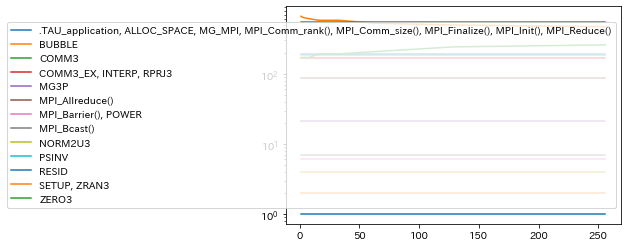

FixClass_sp


,1,2,4,8,16,32,64,256
Name,,,,,,,,
".TAU_application, MPI_Comm_rank(), MPI_Comm_size(), MPI_Init(), MPSP, SETUP_MPI",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
MPI_Bcast(),4.0,1.0,4.0,1.0,4.0,4.0,4.0,4.0


<Figure size 432x288 with 0 Axes>

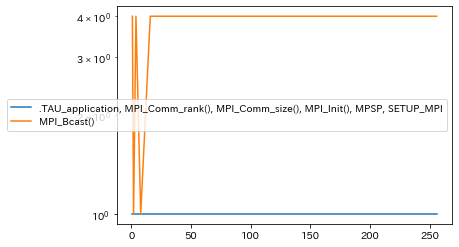

In [5]:
for benchmark in benchmarks:
    print(f"FixClass_{benchmark}")
    FixClassDF = return_summarized_Fixed_dataframe(BenchMark_name = benchmark, fixed="class")
    FixClassDFwithoutNaN = FixClassDF.dropna(how='any', axis=0)
    FixClassDFwithoutNaN
    indice = FixClassDFwithoutNaN.T.index.tolist()
    columns = FixClassDFwithoutNaN.T.columns.tolist()
    plt.figure()
    x = indice
    for column in columns:
        y = FixClassDFwithoutNaN.loc[column]
        plt.plot(x, y, label=column)
    plt.yscale('log')
    plt.legend()
    plt.show()

## 以下記述移行予定

FixProcess_cg


<Figure size 432x288 with 0 Axes>

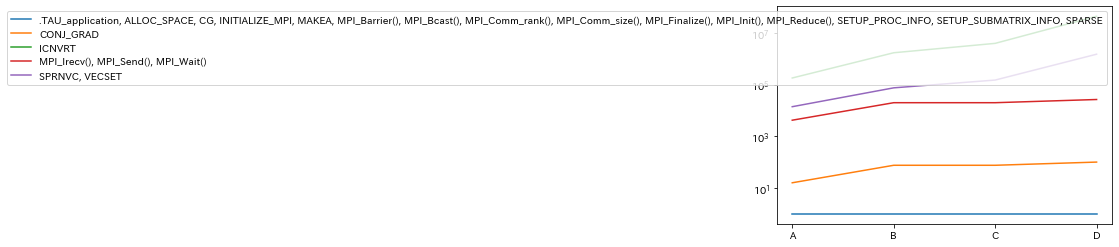

,A,B,C,D
Name,,,,
ICNVRT,180347,1706010.0,3936140.0,44047200.0


In [6]:
# ベンチマークCGでプロセス数を固定したもの

outputDF = 0
for benchmark in ["cg"]:
    print(f"FixProcess_{benchmark}")
    FixProcessDF = return_summarized_Fixed_dataframe(BenchMark_name = benchmark, fixed="process")
    FixProcessDFwithoutNaN = FixProcessDF.dropna(how='any', axis=0)
    outputDF = FixProcessDFwithoutNaN
    indice = FixProcessDFwithoutNaN.T.index.tolist()
    columns = FixProcessDFwithoutNaN.T.columns.tolist()
    plt.figure()
    x = indice
    for column in columns:
        y = FixProcessDFwithoutNaN.loc[column]
        plt.plot(x, y, label=column)
    plt.yscale('log')
    plt.legend()
    plt.show()
ICNVRTfixProcessDF = outputDF.loc["ICNVRT":"ICNVRT"]
ICNVRTfixProcessDF

FixClass_cg


<Figure size 432x288 with 0 Axes>

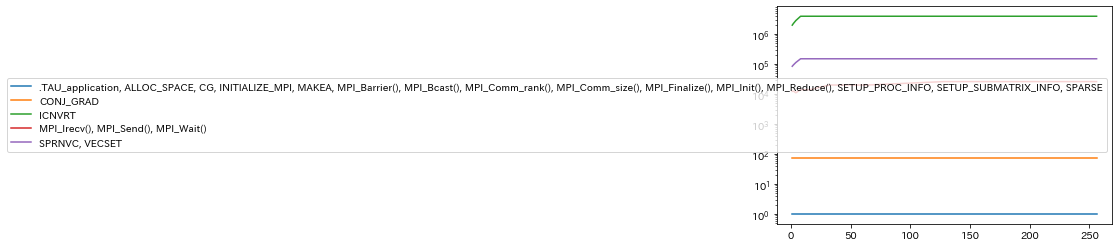

,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
ICNVRT,1984770.0,2263540.0,2821070.0,3936140.0,3936140.0,3936140.0,3936140.0,3936140.0,3936140.0


In [7]:
# ベンチマークCGでベンチマーククラスを固定したもの

outputDF = 0
for benchmark in ["cg"]:
    print(f"FixClass_{benchmark}")
    FixClassDF = return_summarized_Fixed_dataframe(BenchMark_name = benchmark, fixed="class")
    FixClassDFwithoutNaN = FixClassDF.dropna(how='any', axis=0)
    outputDF = FixClassDFwithoutNaN
    indice = FixClassDFwithoutNaN.T.index.tolist()
    columns = FixClassDFwithoutNaN.T.columns.tolist()
    plt.figure()
    x = indice
    for column in columns:
        y = FixClassDFwithoutNaN.loc[column]
        plt.plot(x, y, label=column)
    plt.yscale('log')
    plt.legend()
    plt.show()
ICNVRTfixClassDF = outputDF.loc["ICNVRT":"ICNVRT"]
ICNVRTfixClassDF

In [8]:
intList = ConvertBenchmarkClasses(ICNVRTfixProcessDF.columns.tolist())
intList
ICNVRTfixProcessDF.columns = intList
ICNVRTfixProcessDF
ICNVRTfixClassDF

[1, 4, 16, 256]

,1,4,16,256
Name,,,,
ICNVRT,180347,1706010.0,3936140.0,44047200.0


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
ICNVRT,1984770.0,2263540.0,2821070.0,3936140.0,3936140.0,3936140.0,3936140.0,3936140.0,3936140.0


fixProcess用入力

```
PARAMETER p
POINTS (1) (4) (16)

REGION example
METRIC time
DATA 180347 180347 180347
DATA 1706010.0 1706010.0 1706010.0
DATA 3936140.0 3936140.0 3936140.0
```

fixProcess用出力

```
Callpath: example
	Metric: time
		Measurement point: (1.00E+00) Mean: 1.80E+05 Median: 1.80E+05
		Measurement point: (4.00E+00) Mean: 1.71E+06 Median: 1.71E+06
		Measurement point: (1.60E+01) Mean: 3.94E+06 Median: 3.94E+06
		Model: -3590464.6990329633 + 3759195.349891038 * p^(1/4)
		RSS: 8.79E+09
		Adjusted R^2: 9.98E-01
```

fixClass用入力

```
PARAMETER p
POINTS (1) (2) (4) (8) (16) (32) (64) (128)

REGION example
METRIC time
DATA 1984770.0 1984770.0 1984770.0
DATA 2263540.0 2263540.0 2263540.0
DATA 2821070.0 2821070.0 2821070.0
DATA 3936140.0 3936140.0 3936140.0
DATA 3936140.0 3936140.0 3936140.0
DATA 3936140.0 3936140.0 3936140.0
DATA 3936140.0 3936140.0 3936140.0
DATA 3936140.0 3936140.0 3936140.0
```

fixClass用出力


```
Callpath: example
	Metric: time
		Measurement point: (1.00E+00) Mean: 1.98E+06 Median: 1.98E+06
		Measurement point: (2.00E+00) Mean: 2.26E+06 Median: 2.26E+06
		Measurement point: (4.00E+00) Mean: 2.82E+06 Median: 2.82E+06
		Measurement point: (8.00E+00) Mean: 3.94E+06 Median: 3.94E+06
		Measurement point: (1.60E+01) Mean: 3.94E+06 Median: 3.94E+06
		Measurement point: (3.20E+01) Mean: 3.94E+06 Median: 3.94E+06
		Measurement point: (6.40E+01) Mean: 3.94E+06 Median: 3.94E+06
		Measurement point: (1.28E+02) Mean: 3.94E+06 Median: 3.94E+06
		Model: 2286768.3333333326 + 301997.61904761934 * log2(p)^(1)
		RSS: 2.18E+12
		Adjusted R^2: 4.96E-01
```


<Figure size 2000x2000 with 0 Axes>

Text(0, 0.5, '関数コール回数')

Text(0.5, 0, '問題サイズ[A=1, B=4, C=16, D=256]')

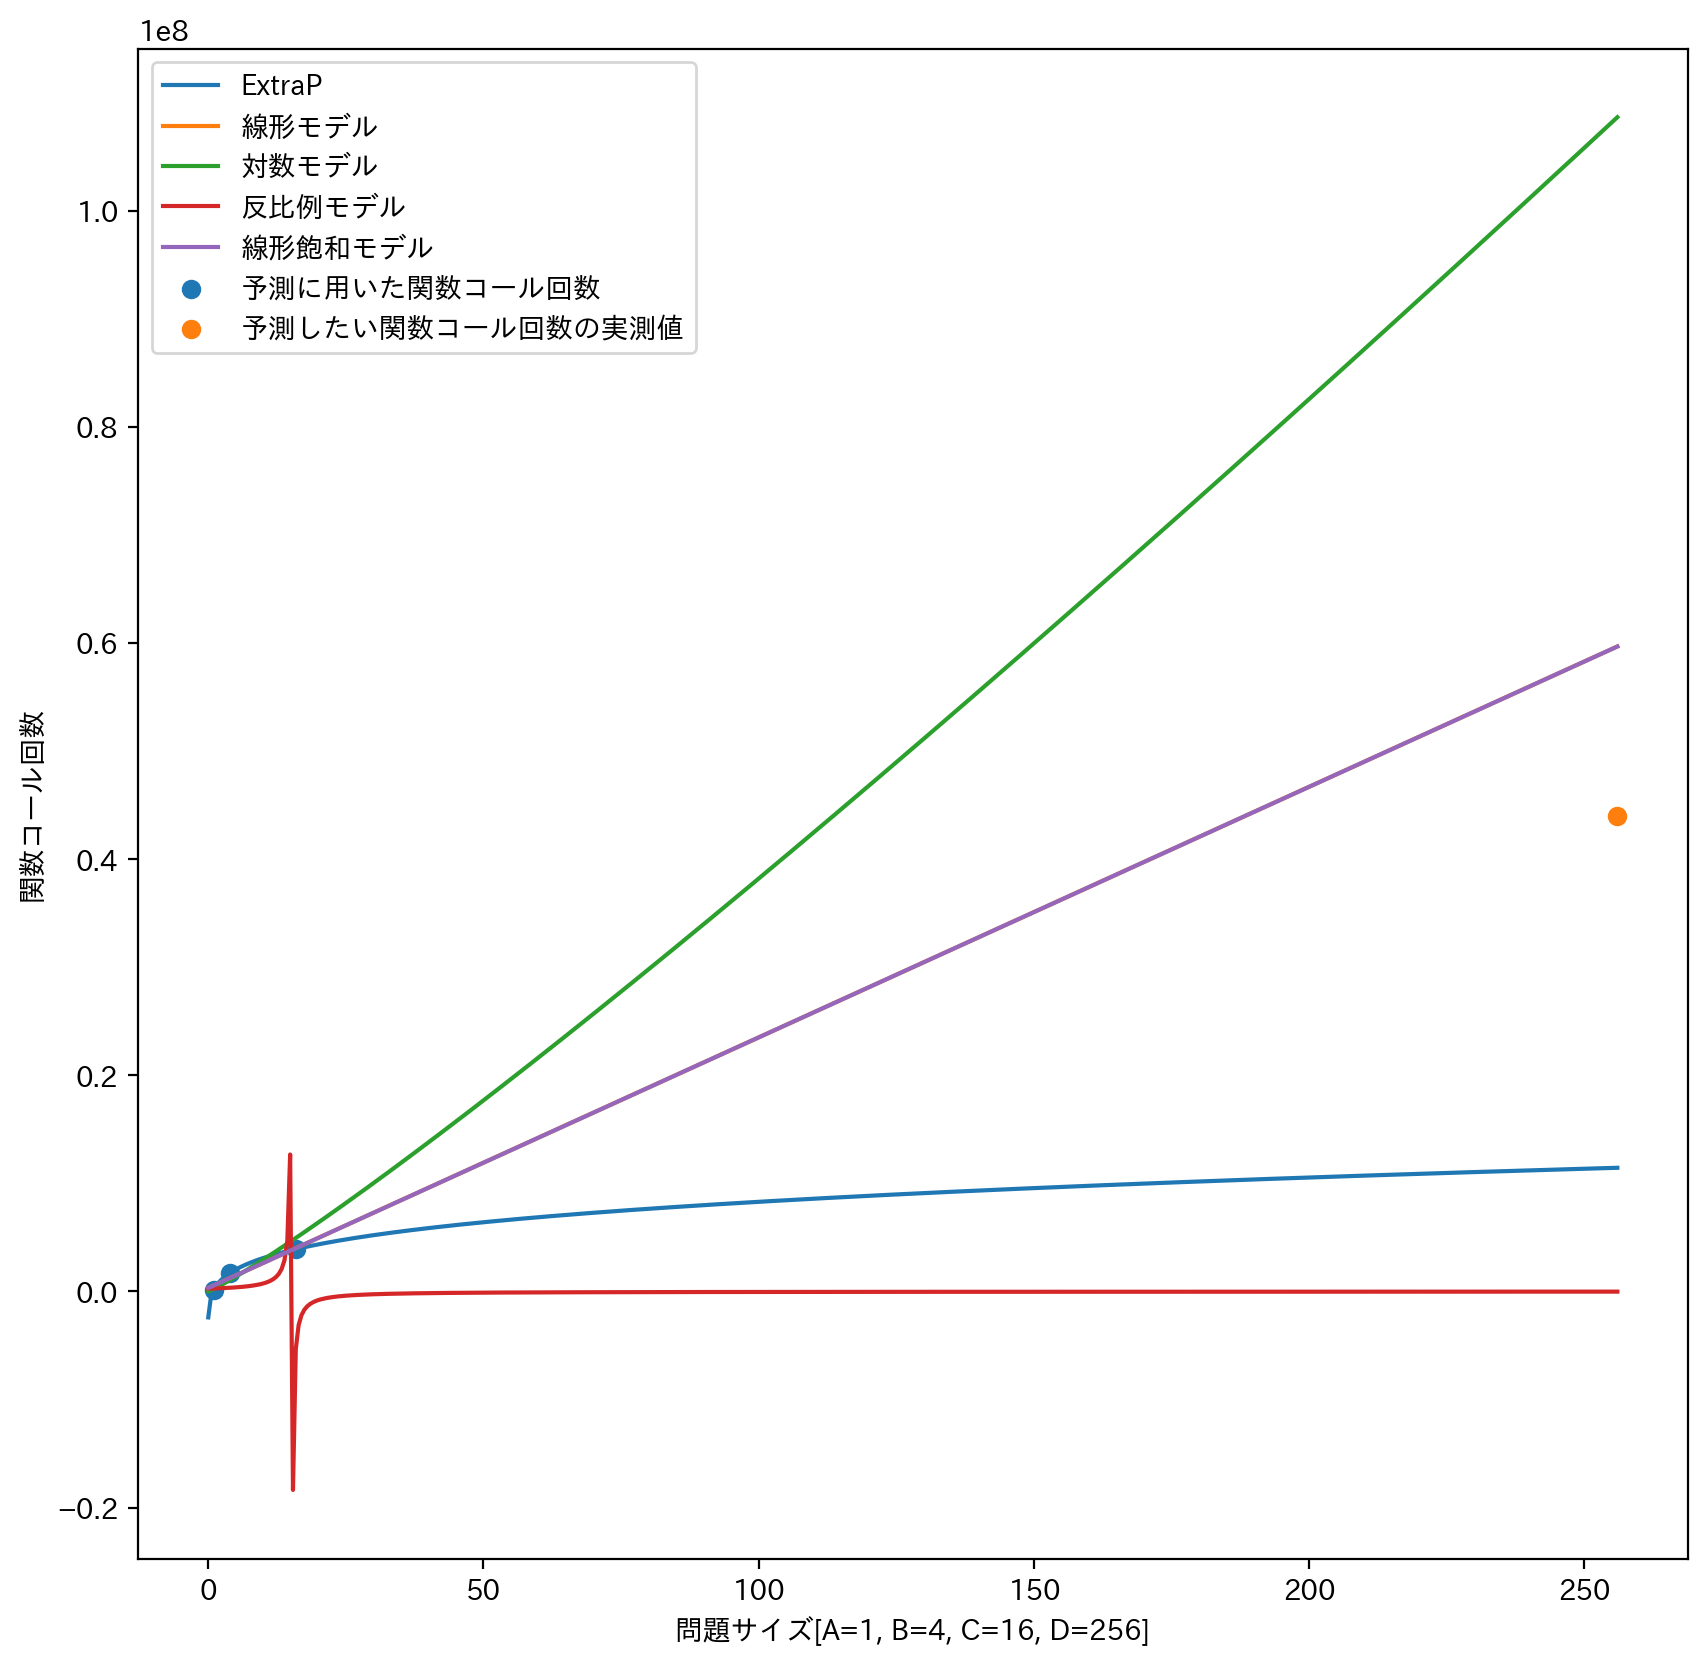

In [9]:
plt.figure(figsize=(10,10),dpi=200)

# Extra-PでfixProcessデータを入力して出力したモデルの図時
plot_x = np.linspace(0.01, 256, 500)
# -3590464.6990329633 + 3759195.349891038 * p^(1/4)
plot_y = []
for x in plot_x:
    plot_y.append(-3590464.6990329633 + 3759195.349891038 * x**(1/4))
plt.plot(plot_x, plot_y, label="ExtraP")

x = [1, 4, 16]
y = [180347, 1706010, 3936140]
x = np.array(x).reshape(-1,1)
y = np.array(y).reshape(-1,1)
plt.scatter(x, y, marker="o", label="予測に用いた関数コール回数")
plot_x = np.array(plot_x).reshape(-1, 1)
x_target = [256]
y_target = [44047200]
plt.scatter(x_target, y_target, marker="o", label="予測したい関数コール回数の実測値")

# 線形モデル
model_lin = ModelLin(x, y, "CG", "ICNVRT", test_ratio=0)
model_lin.calc_lr()
plot_y_lin = model_lin.predict(plot_x)
plt.plot(plot_x, plot_y_lin, label="線形モデル")
# logモデル
model_log10 = ModelLog10(x, y, "CG", "ICNVRT", test_ratio=0)
model_log10.calc_lr()
plot_y_log10 = model_log10.predict(plot_x)
plt.plot(plot_x, plot_y_log10, label="対数モデル")
# 反比例モデル
model_ip = ModelIP(x, y, "CG", "ICNVRT", test_ratio=0)
model_ip.calc_lr()
plot_y_ip = model_ip.predict(plot_x)
plt.plot(plot_x, plot_y_ip, label="反比例モデル")
# 線形飽和モデル
model_branch = ModelBranch(x, y, "CG", "ICNVRT", test_ratio=0)
model_branch.calc_lr()
plot_y_branch = model_branch.predict(plot_x)
plt.plot(plot_x, plot_y_branch, label="線形飽和モデル")
# 凡例の表示
plt.legend()
# 軸ラベルの設定
plt.ylabel("関数コール回数")
plt.xlabel("問題サイズ[A=1, B=4, C=16, D=256]")


<Figure size 2000x2000 with 0 Axes>

Text(0, 0.5, '関数コール回数')

Text(0.5, 0, '実行コア数')

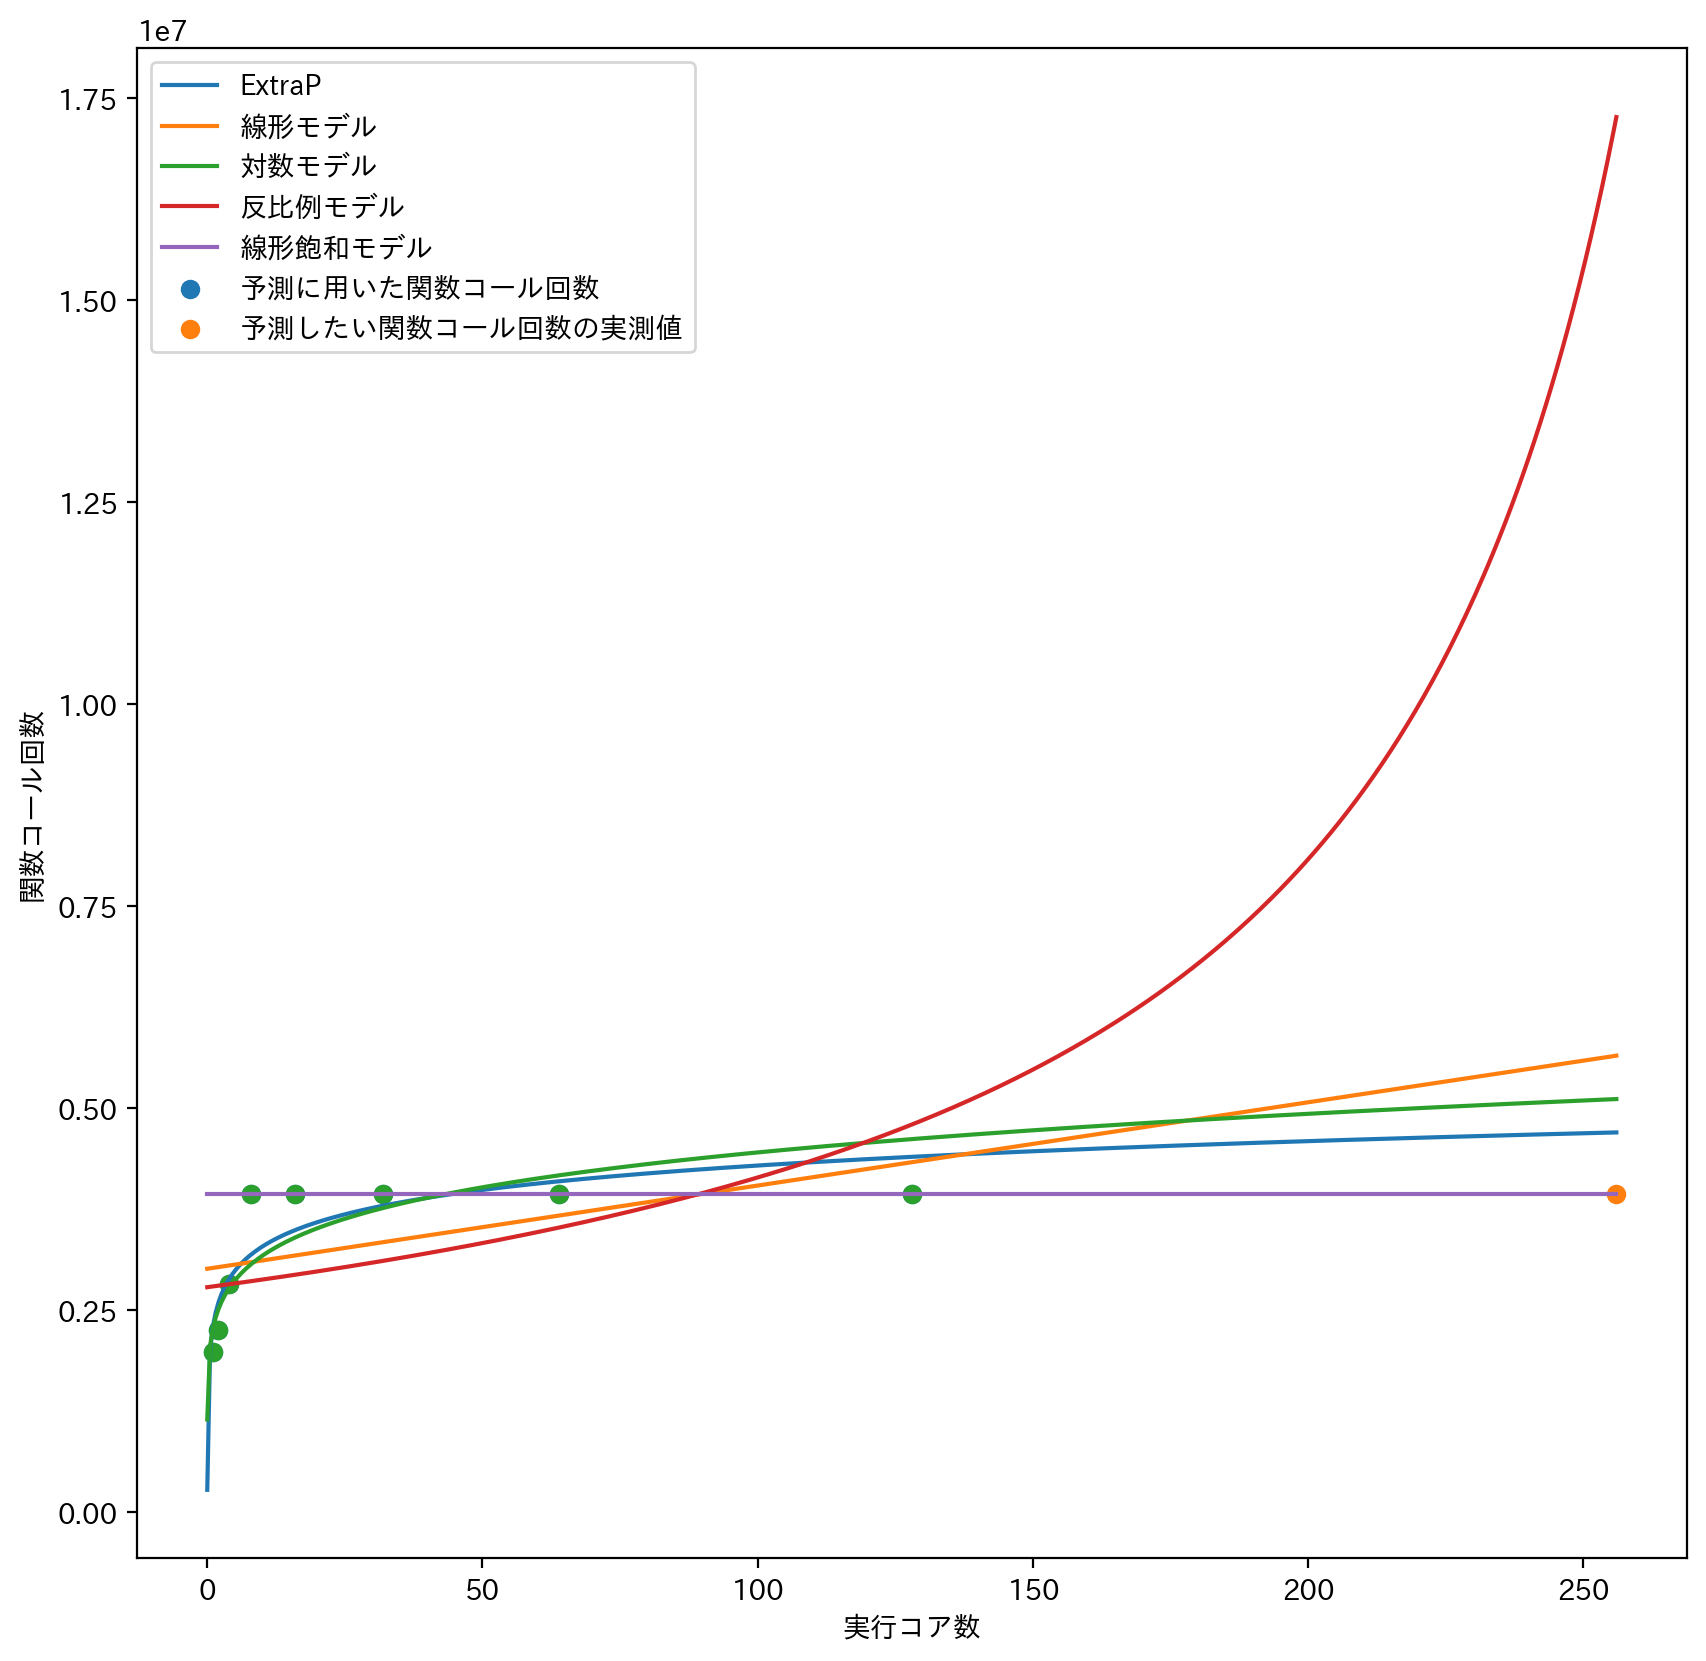

In [10]:
plt.figure(figsize=(10,10),dpi=200)

# Extra-PでfixProcessデータを入力して出力したモデルの図時
plot_x = np.linspace(0.01, 256, 500)
# -3590464.6990329633 + 3759195.349891038 * p^(1/4)
plot_y = []
for x in plot_x:
    plot_y.append(2286768.3333333326 + 301997.61904761934 * math.log2(x)**(1))
plt.plot(plot_x, plot_y, label="ExtraP")

x = [1, 2, 4, 8, 16, 32, 64, 128]
y = [1984770.0, 2263540.0, 2821070.0, 3936140.0, 3936140.0, 3936140.0, 3936140.0, 3936140.0]
x = np.array(x).reshape(-1,1)
y = np.array(y).reshape(-1, 1)
plt.scatter(x, y, marker="o", label="予測に用いた関数コール回数")
plot_x = np.array(plot_x).reshape(-1, 1)
x_target = [256]
y_target = [3936140]
plt.scatter(x_target, y_target, marker="o", label="予測したい関数コール回数の実測値")

# 線形モデル
model_lin = ModelLin(x, y, "CG", "ICNVRT", test_ratio=0)
model_lin.calc_lr()
plot_y_lin = model_lin.predict(plot_x)
plt.plot(plot_x, plot_y_lin, label="線形モデル")
# 対数モデル
model_log10 = ModelLog10(x, y, "CG", "ICNVRT", test_ratio=0)
model_log10.calc_lr()
plot_y_log10 = model_log10.predict(plot_x)
plt.plot(plot_x, plot_y_log10, label="対数モデル")
# 反比例モデル
model_ip = ModelIP(x, y, "CG", "ICNVRT", test_ratio=0)
model_ip.calc_lr()
plot_y_ip = model_ip.predict(plot_x)
plt.plot(plot_x, plot_y_ip, label="反比例モデル")
# 線形飽和モデル
model_branch = ModelBranch(x, y, "CG", "ICNVRT", test_ratio=0)
model_branch.calc_lr()
plot_y_branch = model_branch.predict(plot_x)
plt.plot(plot_x, plot_y_branch, label="線形飽和モデル")
# 凡例の表示
plt.legend()
# 軸ラベルの設定
plt.ylabel("関数コール回数")
plt.xlabel("実行コア数")

plt.scatter(x, y, marker="o")

In [11]:
for benchmark in benchmarks:
    if benchmark == "lu":
        print(f"----------{benchmark}----------")
        return_ErrorRateFixedProcessDF(benchmark=benchmark, FixProcess=64, predict_class="D")

----------lu----------


,"['A', 'B', 'C', 'D']","['A', 'B', 'C']","['A', 'B']",['A']
.TAU_application,0.0,0.0,0.0,0.0
ALLOC_SPACE,0.0,0.0,0.0,0.0
APPLU,0.0,0.0,0.0,0.0
BCAST_INPUTS,0.0,0.0,0.0,0.0
BLTS,51.229,56.76,33.328,99.027
BUTS,51.229,56.76,33.328,99.027
ERHS,0.0,0.0,0.0,0.0
ERROR,0.0,0.0,0.0,0.0
EXACT,74.793,73.772,75.595,99.909
EXCHANGE_1,2.763,15.079,576.146,87.265


In [12]:
return_FixedClassModelDF()

,"[1, 2, 4, 8, 16, 32, 64, 128, 256]","[1, 2, 4, 8, 16, 32, 64, 128]","[1, 2, 4, 8, 16, 32]","[1, 2, 4, 8]","[1, 2]",[1]
.TAU_application,<__main__.ModelLin object at 0x7f1303532ee0>,<__main__.ModelLin object at 0x7f1303661eb0>,<__main__.ModelLin object at 0x7f1303661ac0>,<__main__.ModelLin object at 0x7f1303661e50>,<__main__.ModelLin object at 0x7f1303661ee0>,<__main__.ModelLin object at 0x7f13036597c0>
ALLOC_SPACE,<__main__.ModelLin object at 0x7f1303661e80>,<__main__.ModelLin object at 0x7f1303659e50>,<__main__.ModelLin object at 0x7f1303659fa0>,<__main__.ModelLin object at 0x7f1303659fd0>,<__main__.ModelLin object at 0x7f1303659d60>,<__main__.ModelLin object at 0x7f1303659ac0>
CG,<__main__.ModelLin object at 0x7f1303659820>,<__main__.ModelLin object at 0x7f1303659700>,<__main__.ModelLin object at 0x7f1303659d00>,<__main__.ModelLin object at 0x7f1303659550>,<__main__.ModelLin object at 0x7f13036597f0>,<__main__.ModelLin object at 0x7f1303659c10>
CONJ_GRAD,<__main__.ModelLin object at 0x7f13036592b0>,<__main__.ModelLin object at 0x7f1303659910>,<__main__.ModelLin object at 0x7f1303659d30>,<__main__.ModelLin object at 0x7f13036596d0>,<__main__.ModelLin object at 0x7f13036599d0>,<__main__.ModelLin object at 0x7f1303659ee0>
ICNVRT,<__main__.ModelBranch object at 0x7f1303550910>,<__main__.ModelBranch object at 0x7f1303550ee0>,<__main__.ModelBranch object at 0x7f1303550d60>,<__main__.ModelLin object at 0x7f1303659c40>,<__main__.ModelLin object at 0x7f1303550f10>,<__main__.ModelLin object at 0x7f13036590a0>
INITIALIZE_MPI,<__main__.ModelLin object at 0x7f1303550790>,<__main__.ModelLin object at 0x7f1303659cd0>,<__main__.ModelLin object at 0x7f1303550df0>,<__main__.ModelLin object at 0x7f13035507f0>,<__main__.ModelLin object at 0x7f1303550370>,<__main__.ModelLin object at 0x7f1303550b50>
MAKEA,<__main__.ModelLin object at 0x7f1303550dc0>,<__main__.ModelLin object at 0x7f1303550a00>,<__main__.ModelLin object at 0x7f13035503a0>,<__main__.ModelLin object at 0x7f1303550ac0>,<__main__.ModelLin object at 0x7f1303550700>,<__main__.ModelLin object at 0x7f1303550fa0>
MPI_Barrier(),<__main__.ModelLin object at 0x7f1303550d00>,<__main__.ModelLin object at 0x7f1303550af0>,<__main__.ModelLin object at 0x7f1303544cd0>,<__main__.ModelLin object at 0x7f1303550e50>,<__main__.ModelLin object at 0x7f1303544fa0>,<__main__.ModelLin object at 0x7f1303550e20>
MPI_Bcast(),<__main__.ModelLin object at 0x7f1303544c70>,<__main__.ModelLin object at 0x7f1303544d60>,<__main__.ModelLin object at 0x7f1303544f40>,<__main__.ModelLin object at 0x7f1303544af0>,<__main__.ModelLin object at 0x7f1303544f70>,<__main__.ModelLin object at 0x7f1303544700>
MPI_Comm_rank(),<__main__.ModelLin object at 0x7f1303544ee0>,<__main__.ModelLin object at 0x7f1303544bb0>,<__main__.ModelLin object at 0x7f13035c7250>,<__main__.ModelLin object at 0x7f1303544e20>,<__main__.ModelLin object at 0x7f13035c72e0>,<__main__.ModelLin object at 0x7f1303544730>


In [13]:
for benchmark in benchmarks:
    if benchmark == "ft":
        print(f"----------{benchmark}----------")
        return_ErrorRateFixedClassDF(benchmark=benchmark, FixClass="B", predict_process=256)

----------ft----------


,"[1, 2, 4, 8, 16, 32, 64, 128, 256]","[1, 2, 4, 8, 16, 32, 64, 128]","[1, 2, 4, 8, 16, 32]","[1, 2, 4, 8]","[1, 2]",[1]
.TAU_application,0.0,0.0,0.0,0.0,0.0,0.0
ALLOC_SPACE,0.0,0.0,0.0,0.0,0.0,0.0
CFFTS1,0.0,0.0,0.0,0.0,11545.454,45.454
CFFTZ,7.274,48.067,68612.903,366042.857,2494357887999956992.0,16.363
CHECKSUM,0.0,0.0,0.0,0.0,17779.999,70.0
COMPUTE_INDEXMAP,0.0,0.0,0.0,0.0,0.0,0.0
COMPUTE_INITIAL_CONDITIONS,0.0,0.0,0.0,0.0,0.0,0.0
EVOLVE,0.0,0.0,0.0,0.0,17779.999,70.0
FFT,0.0,0.0,0.0,0.0,100.225,63.636
FFTZ2,8.011,55.055,68613.015,366043.843,4658374629091588096.0,6.43
